<div id="colab_button">
  <h1>Data exploration of diabetes hospital admissions </h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/bastionlab/blob/v0.3.7/docs/docs/how-to-guides/diabetes_p1.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
______________________________________________________

Despite major recent technological breakthroughs in cybersecurity and privacy, secure off-premises data science collaboration has remained out of reach. This is a major problem for the health sector which has so much to gain from the power of data but so much at risk when it comes to patients' highly sensitive records.

BastionLab's goal is to make this issue disappear so that remote data science collaborations can happen safely in the medical industry. Its framework lets data owners set a strict access policies on datasets for collaborators and enforces that data scientists can explore or train ML models while never accessing the raw data.

In this guide, we will explore a dataset of diabetic patients admitted to hospital in the US over a ten year period. Diabetes is a disease that affects over 10% of the US population and can lead to serious health complications. The dataset contains 51 columns of data, including readmission to hospital, changes to medication and primary, secondary and terciary patient diagnoses.

First, we will see how the data owner can upload a dataset to BastionLab and how a data scientist can then connect to BastionLab and **clean the dataset**. Then we'll go on analysing it - showing it is possible to do normal data science work without accessing the data in clear.

But before we can do that, let's get everything set up!

## Pre-requisites
___________________________________________

### Installation and dataset

In order to run this notebook, we need to:
- Ensure we have [Python3.7](https://www.python.org/downloads/) (or greater) and [Python Pip](https://pypi.org/project/pip/) installed
- Install [BastionLab](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/) and the [BastionLab server](https://pypi.org/project/bastionlab-server/0.3.7/) pip packages
- [Download the dataset](https://drive.google.com/file/d/1NPQoKKG3CdvXTNkHVNYhRQZ8GGiPNlvI/view?usp=share_link) we will be using in this notebook.

You can download the BastionLab pip packages and the dataset by running the following code block.

>To find out about other ways you can install and run BastionLab, see our [Installation page](https://bastionlab.readthedocs.io/en/latest/docs/getting-started/installation/).

In [ ]:
# installing BastionLab client & server packages
!pip install bastionlab
!pip install bastionlab_server

# dowloading the dataset using Google Drive tool gdown
!pip install gdown
!pip install --upgrade --no-cache-dir gdown
!gdown "1NPQoKKG3CdvXTNkHVNYhRQZ8GGiPNlvI"

The dataset we are using for this how-to guide is based on the Diabetes 130-US hospitals, for years 1999-2008. It contains 10 years of information on diabetes admissions from 130 US hospitals. It includes over 50 features representing patient and hospital outcomes.

>For more detailed information on the dataset, you can check out the description and full dataset by following this [link](https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).

This dataset had already been pre-processed before publication which stopped us from showing you some key data cleaning steps. We made a few modifications to replace some pre-grouped data columns with randomly populated data. You can check out exactly how we did this using the Polars data science library [here](https://colab.research.google.com/drive/174EJvK8u8mGGWb6ypLH9SKaeRnX-pEou?usp=share_link). 

## Data owner setup
___________________________________________

### Launching the server

Let's start by putting ourselves in the shoes of the data owner.

But first, let's get the BastionLab server running.

In production we recommend this is done using our Docker image, but for testing purposes you can use our `bastionlab_server` package, which removes the need for user authentication.

In [193]:
# launch bastionlab_server test package
import bastionlab_server

srv = bastionlab_server.start()

BastionLab server (version 0.3.7) already installed
Libtorch (version 1.13.1) already installed
TLS certificates already generated
Bastionlab server is now running on port 50056


>*For more details on how you can set up the server using our Docker image, check out our [Installation Tutorial](../getting-started/installation.md).*

### Connecting to the server
Next, we will connect to the server in order to be able to upload the dataset.

In [194]:
# connecting to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

### Creating a custom privacy policy

We can now create a [custom access policy](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/defining_policy_privacy/) for the dataset which determines how much access collaborators will get to the dataset. 

In this example, we create a policy with the following configuration:

->  `Aggregation(min_agg_size=10):` Any data extracted from the dataset should be the result of an aggregation of at least ten rows.

->  `unsafe_handling=Reject()`: Any attempted query which breaches this policy will be rejected by the server.

->  `savable=True`: The data scientist can save changes made to the dataset in BastionLab (this will create a new dataset - it will not overwrite the original dataset).


In [195]:
from bastionlab.polars.policy import Policy, Aggregation, Reject

# defining the dataset's privacy policy
policy = Policy(Aggregation(min_agg_size=10), unsafe_handling=Reject(), savable=True)

### Uploading the dataset

Now that the policy has been created, we can upload the dataset to the BastionLab server instance.

Firstly, we need to convert our CSV file into a Polars DataFrame by using the Polars `read_csv` function, supplying the path to the CSV file as a string argument.

Next, we use BastionLab's `client.polars.send_df` to upload the dataframe with our custom policy.

Finally, we save the FetchableLazyFrame using the `save` method with no arguments. We can make a note of the FetchableLazyFrame's identifier to be shared with data scientists to help them to remotely access the FetchableLazyFrame!

>Note we need to save FetchableLazyFrames to avoid them being lost when the server is stopped and restarted or crashes.

In [196]:
import polars as pl

# converting the dataset into a Polars dataframe
df = pl.read_csv("updated_diabetes_data.csv")

# uploading the dataframe, the custom privacy policy
# and the column we want to forbid to BastionLab's server
rdf = client.polars.send_df(df, policy=policy)

# saving the FetchableLazyFrame
rdf.save()
# get and print out a copy of the RDF identifier string
ID = rdf.identifier
print(ID)

63c8152d-f5af-41ec-b22c-aea51a8465b5


`send_df()` will return a FetchableLazyFrame instance, which we will work with directly from now on. 

>Note that we talk about two types of LazyFrames in BastionLab: `RemoteLazyFrames` and `FetchableLazyFrames`. 

> In BastionLab, when we run a query, it is not immediately executed. Like with Polar's LazyFrames, pending queries are only executed when we call `collect`. `FetchableLazyFrames` are BastionLab's remote lazy frames when there are no pending queries to run, either because we have just uploaded or got the dataframe using `get_df` or because we have already ran `collect` after our latest query. To display these lazy frames we call the `fetch` method, which will verify that the data frame is safe to display, i.e. is it the result of a safe aggregated query as specified in the privacy policy.

> A `RemoteLazyFrame` is just a `FetchableLazyFrame` with pending queries still to run (as they have not yet been `collected`). When we call `collect()` these operations are run server-side and the result of this is our `FetchableLazyFrame`.

Let's finish off by testing what happens if we breach our security policy by trying to display an entire column from our dataset with the `collect().fetch()` methods. 

>*You can learn more about how to use both of those methods in [our quick tour](https://bastionlab.readthedocs.io/en/latest/docs/quick-tour/quick-tour/#running-queries).*

In [197]:
rdf.select("age").collect().fetch()

The query has been rejected by the data owner.


Instead of getting back the results of our query, we see an error message: `The query has been rejected by the data owner.`

We cannot view the output of the query because it does not aggregate at least 10 rows of data as specified in our privacy policy. It tries to print out individual rows instead!

Now that the dataset has been uploaded, it's time for our data scientists to get working... 

The data owner can now connection their connection to the server.

In [198]:
connection.close()

## Data scientist #1 setup
__________________________________________

### Connecting to the dataset

We'll now jump into the role of the data scientist responsible for cleaning the dataset for this data analysis project.

We first need to connect to the `bastion_lab` server and get a FetchableLazyFrame instance of the dataset. We'll use' the `get_df()` method and supply it with the id shared with us by the data owner to do this.

We store our FetchableLazyFrame in the `rdf` variable which we'll be working with from here on.

In [199]:
connection = Connection("localhost")
client = connection.client

# selecting the FetchableLazyFrame(s) we'll be working with
rdf = client.polars.get_df(ID)
rdf

FetchableLazyFrame(identifier=63c8152d-f5af-41ec-b22c-aea51a8465b5)

Let's display the dataset's columns to confirm we are connected to the correct one.

In [200]:
print(rdf.columns)

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


Everything is as expected! We can now start our data exploration. 

## Data cleaning
__________________________________________


### Dropping columns
You may have noticed, this dataset contains a lot of columns! This is great as it it gives us a wide choice of correlations to explore. However, we will not have time to explore all of them in this analysis! We can therefore drop the columns that we won't be using- either because they are irrelavant, or because they didn't lead us to the most interesting correlations for this analysis!

We can do this by using the`drop` method, providing it with a list of the names of columns to be dropped. This is a RemoteLazyFrame method which corresponds directly to the [Polars drop() function](https://pola-rs.github.io/polars/py-polars/html/reference/lazyframe/api/polars.LazyFrame.drop.html#polars.LazyFrame.drop).

In [201]:
# list of column names we wish to remove from our RemoteLazyFrame
to_drop = [
    "encounter_id",
    "patient_nbr",
    "weight",
    "discharge_disposition_id",
    "admission_source_id",
    "time_in_hospital",
    "payer_code",
    "medical_specialty",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_inpatient",
    "number_diagnoses",
    "diabetesMed",
]

# replace rdf with our updated RemoteLazyFrame with to_drop columns deleted
rdf = rdf.drop(to_drop)

There are now 36 columns to work with intead of 51- this will make the RemoteLazyFrame a little easier to work with!


### Checking for null values

We now want to assess how many null values we have in each column. This will help us to know if we have enough data to draw meaningful conclusions from each column and gives us the chance to fill or delete null values if relevant.

However, based on the description of the dataset shared with us by the data owner, we know that some column cells have been filled with '?' instead of being left blank.

Before we can get an accurate picture of null values, we first need to replace all these '?' values with null values. We will do this by using [Polars .when().then().otherwise()` functions](https://pola-rs.github.io/polars/py-polars/html/reference/expressions/api/polars.when.html). 

One final hurdle is that we can only search and replace '?' strings in columns with the 'Utf8' (string) datatype- otherwise an error will be produced. We must therefore firstly grab pl.Utf8 columns only and apply our search and replace operation to these strings!

In [202]:
# step one: getting a list of all Utf8/string columns
selects = rdf.select(pl.col(pl.Utf8)).columns

# step two: we replace all '? cells in these columns with null values
rdf = rdf.with_columns(
    [
        pl.when(pl.col(x) == "?").then(None).otherwise(pl.col(x)).keep_name()
        for x in selects
    ]
)

In step two, we use the Polars `with_columns` function to add our new columns with null values instead of question marks to our RemoteLazyFrame. By using the `keep_name` function, these columns keep their original column name and therefore replace the original columns in the dataset. We save the result as `rdf`, storing the updated version of the dataset in our `rdf` variable.

Now that this is done, we can go ahead and calculate how many null values each column contains.

We do this by iterating over all the columns and getting a percentage of the `sum` of all the value that return `True` to the `is_null` function.

In [203]:
# getting every columns percentage of null values in the RemoteLazyFrame
percent_missing = rdf.select(
    [
        pl.all().is_null().sum() * 100 / pl.all().count(),
    ]
)

We can then view the percentage of null values for each column as a two-column list by using Polars `melt` function to flip the query results from a 2 row by 5 column grid, to a 2 column by 5 row grid. We use the `sort` function to show the columns in order from the column with the highest percentage of null values to the lowest.

Finally, we remove any columns with no null values from our output since they are not of interest to us here.

In [204]:
# melt table to a two-column table with the column name 'column' and corresponding percetage of null values 'null values', sort in descending order and display
percent_missing = percent_missing.melt(
    variable_name="column name",
    value_name="null values (%)",
).sort(pl.col("null values (%)"), reverse=True)

# filter out columns with no null values and display
percent_missing.filter(pl.col("null values (%)") > 0).collect().fetch()

column name,null values (%)
str,f64
"""max_glu_serum""",94.746772
"""A1Cresult""",83.277322
"""readmitted""",53.911916
"""race""",2.233555
"""diag_3""",1.398306
"""diag_2""",0.351787
"""diag_1""",0.020636


There are several strategies for dealing with null values such as deleting these rows from the dataset with the `drop_nulls` method or filling null values with the `fill_null` method. But in our case, we are just happy to have visibility over which columns including null values and to what extent so that we can handle and analyse these columns with this in mind.

### Grouping data: ICD-9 medical codes
Grouping data is going to be the largest and most crucial task in this data cleaning job. This is a dataset with a low of wide-ranging numerical values which need to be grouped so that our data analysts can gain meaningul insights.

Let's start with our diagnoses columns: `diag_1`, `diag_2` and `diag_3`.

These columns contain the primary, secondary and terciary diagnoses given to patients. These diagnoses are given using [ICD-9 medical codes](https://en.wikipedia.org/wiki/List_of_ICD-9_codes) which are three digit codes ranging from 1 to 1000, as well as E800–E999 codes and V01–V82 code.

By grabbing all the unique values in the `diag_1` column and counting them, we can see that we have over 700 different values in this column!

In [205]:
tmp = rdf.select("diag_1").unique()
tmp.select(pl.col("diag_1").count()).collect().fetch()

diag_1
u32
717


Standard groupings of these codes have already been designed. What we want to do is replace the hundreds of unique codes we have in our our diagnoses columns with these groupings!

To do this, we will again use Polars `when().then().otherwise()` functions to  perform a find and replace operation. We will use `when()` to check if the codes in each cell are either E or V codes or fall within a certain numerical range.

However, these diagnoses columns are currently string columns, since the E and V codes are not entirely numerical. This is problematic since we cannot perform numerical comparisons on these cells and we cannot convert the column type to a numerical one because of these 'E' and 'V' values!

We will solve this problem in three steps:

1) We will find and replace all E codes with a "-1" value and V codes with a "-2" value.

2) We will `select()` our columns and `cast()` all values in these columns to float values.

3) We will perform the find and replace operation to group all ICD-9 codes into their associated group- of which there are 17, plus E codes and V codes.

In [206]:
# iterate over the three diagnoses columns
for col in ["diag_1", "diag_2", "diag_3"]:
    # step one: replace troublesome E and V codes with temporary -1 and -2 codes
    rdf = rdf.with_columns(
        [
            pl.when(
                pl.col(col).str.starts_with("E")
            )  # use Polars str.starts_with method to identify E codes
            .then("-1")
            .when(pl.col(col).str.starts_with("V"))
            .then("-2")
            .otherwise(pl.col(col))
            .keep_name()
        ]
    )

    # step two: cast all values in column to float values
    rdf = rdf.with_columns([pl.col(col).cast(pl.Float64)])

    # step three: replace all codes with their corresponding group
    rdf = rdf.with_columns(
        [
            pl.when(pl.col(col) >= 800)
            .then("injury and poisoning")
            .when(pl.col(col) >= 780)
            .then("symptoms, signs & ill-defined")
            .when(pl.col(col) >= 760)
            .then("perinatal")
            .when(pl.col(col) >= 740)
            .then("congenital anomalies")
            .when(pl.col(col) >= 710)
            .then("musculoskeletal & connective tissue")
            .when(pl.col(col) >= 680)
            .then("skin")
            .when(pl.col(col) >= 630)
            .then("pregnancy, childbirth and peurperium")
            .when(pl.col(col) >= 580)
            .then("genitourinary")
            .when(pl.col(col) >= 520)
            .then("digestive")
            .when(pl.col(col) >= 460)
            .then("respiratory")
            .when(pl.col(col) >= 390)
            .then("circulatory")
            .when(pl.col(col) >= 320)
            .then("nervous system and sense organs")
            .when(pl.col(col) >= 290)
            .then("mental disorders")
            .when(pl.col(col) >= 280)
            .then("blood and blood-forming organs")
            .when(pl.col(col) >= 240)
            .then("neoplasms")
            .when(pl.col(col) >= 140)
            .then("endocrine, nutritional, metabolic and immunity")
            .when(pl.col(col) >= 1)
            .then("infectious and parasitic")
            .when(pl.col(col) == -1)
            .then("E code (injury)")
            .when(pl.col(col) == -2)
            .then("V code (other)")
            .otherwise(
                None
            )  # otherwise (null values) keep original value from the column
            .alias(
                col
            )  # give resulting column same name as previously- therefore replacing old columns
        ]
    )

By performing the same query as previously to count `diag_1`'s unique values, we see there is now a much more manageable 19 labels in our data column! This will be similar for the `diag_2` and `diag_3` columns.

In [207]:
tmp = rdf.select("diag_1").unique()
tmp.select(pl.col("diag_1").count()).collect().fetch()

diag_1
u32
19


We notice in our project brief that there is only 1 E code value in the `diag_1` column, so we will remove this value from our dataset before continuing by using the `filter` function.

In [208]:
rdf = rdf.filter(pl.col("diag_1") != "E code (injury)")

### Grouping data: A1C, max glucose levels and readmittance

We want to group together data in another three other columns using the same `.then().when().otherwise()` methods.

The first two are `A1Cresult`, which contains patients' HbA1c level, and `max_glu_serum`, which contains their blood glucose level. We want to group these into `very high`, `high`, `normal` groups based on levels defined in our project brief.

These columns are both currently string columns, so we will also need to convert them to float values in order to perform numerical comparisons on them.

In [209]:
# cast `max_glu_serum` and `A1Cresult` columns to float values
rdf = rdf.with_columns(
    [pl.col("max_glu_serum").cast(pl.Float64), pl.col("A1Cresult").cast(pl.Float64)]
)

# group values in A1Cresult column
rdf = rdf.with_columns(
    [
        pl.when(pl.col("A1Cresult") >= 8)
        .then("very high")
        .when(pl.col("A1Cresult") >= 7)
        .then("high")
        .when(pl.col("A1Cresult") >= 0)
        .then("normal")
        .otherwise(pl.col("A1Cresult"))
        .keep_name()
    ]
)

# group values in max_glu_serum column
rdf = rdf.with_columns(
    [
        pl.when(pl.col("max_glu_serum") >= 300)
        .then("very high")
        .when(pl.col("max_glu_serum") >= 200)
        .then("high")
        .when(pl.col("max_glu_serum") >= 0)
        .then("normal")
        .otherwise(pl.col("max_glu_serum"))
        .keep_name()
    ]
)

The final column we want to group is the `readmitted` column which records the number of days before any further re-hospitalization linked to the patients' diabetic condition.

We will group this column into `short-term` and `long-term` and `n/a` (not applicable) groups.

Simiar to in previous examples, we must first convert values in this column from strings to integer values.

In [210]:
# cast readmitted column to integer values
rdf = rdf.with_columns([pl.col("readmitted").cast(pl.Int64)])

# group values
rdf = rdf.with_columns(
    [
        pl.when(pl.col("readmitted") < 31)
        .then("short-term")
        .when(pl.col("readmitted") >= 31)
        .then("long-term")
        .otherwise("n/a")
        .keep_name()
    ]
)

### Grouping data: binning ages
The next grouping task we will perform is to group ages into intervals of 10 years. We do this both to increase data privacy and to more easily draw correlations linked to broader age groups.

We won't need to perform an `when().then().otherwise()` query here since BastionLab has its own `ApplyBins` tool.

`ApplyBins` is a PyTorch module and the grouping of numbers takes place in its `forward` function. We can pass PyTorch modules to BastionLab's `apply_udf` function which will apply the `forward` function to any specified columns.

All in all, we just three steps to bin our age column data:

1) We import `ApplyBins` from `bastionlab.polars.utils`.
1) We instantiate our `ApplyBins` PyTorch module class with our bins interval given as the only argument.
2) We use `apply_udf`, providing a list of the column we want to modify and the PyTorch module, `ApplyBins`, that we wish to apply to these columns.

In [211]:
from bastionlab.polars.utils import ApplyBins

# get an instance of ApplyBins module which will bin data into groups of 10
model = ApplyBins(10)

# apply bins to "age" column
rdf = rdf.apply_udf(["age"], model)

> Note, you can create your own custom PyTorch modules and apply them to columns using `apply_udf`. This is BastionLab's way of allowing you to apply custom functions on datasets, whilst restricting what you can do for security reasons. Functionality like `lambda`, `map` and `apply` are blocked by BastionLab as they are too permissive and could be misused.

### Adding columns

Up until this point we have been using the `.when().then().otherwise()` and `with_columns` methods to make changes to existing columns, but by providing a new column name to the `alias` method, we can create a new column.

In the following example, we will create a `is_readmitted` column which will store `False` for all the "n/a" values in our original `readmitted` column and `True` for any other values. This will allow us to quickly query whether certain groups of data have been readmitted or not!

In [212]:
rdf = rdf.with_columns(
    [
        pl.when(pl.col("readmitted") == "n/a")
        .then(False)
        .otherwise(True)
        .alias(
            "is_readmitted"
        )  # ending the .when().then().otherwise() pattern with .alias() allows us to provide a new column name
    ]
)

### Converting column types

We have already seen examples where we have `explicity` converted the datatype of our columns using the `cast` method. Here we will `implicity` convert the datatype by replacing the "yes" and "no" values in our `change` column, which represent whether a patient's medication has been changed, to a boolean True or False value. 

The datatype of this column will be changed automatically by this operation as we can see below.

In [213]:
# print out initial datatype of "change" column

rdf.select("change").dtypes

[polars.datatypes.Utf8]

In [214]:
# replaces Yes/No values with True/False
rdf = rdf.with_columns(
    [pl.when(pl.col("change") == "No").then(False).otherwise(True).keep_name()]
)

# print out datatype of column post find and replace operation
rdf.select("change").dtypes

[polars.datatypes.Boolean]

### Saving our RemoteLazyFrame and disconnecting

Our dataframe is all clean and ready for the next step: data analysis/ visualization. Data scientist #1 is going to be reassigned to another task. They will save their cleaned RemoteLazyFrame and make a note of the identifier to share with data scientist #2.

We need to perform `collect()` before saving or getting an identifier for our RemoteLazyFrame since the `save` method and `identifier` attribute are only available for FetchableLazyFrames.

>Note, the data owner must have set the `savable` option to `True` when uploading the dataframe for this operation to be possible!

In [215]:
rdf.collect().save()
saved_identifier = rdf.collect().identifier
saved_identifier

'57a34384-f881-4059-ae5a-6a7d1483a1ae'

They can now close their connection to the BastionLab server.

In [216]:
connection.close()

### Part II: data analysis and visualization

So data scientist #2 is now ready to begin their analysis of the cleaned dataset. Just like data scientist #1, they will first need to connect to the server and get the FetchableLazyFrame saved by data scientist #1.

In [217]:
# connecting to the server
from bastionlab import Connection

connection = Connection("localhost")
client = connection.client

# get the previously saved dataframe
rdf = client.polars.get_df(saved_identifier)
rdf

FetchableLazyFrame(identifier=57a34384-f881-4059-ae5a-6a7d1483a1ae)

We can again confirm that the original privacy policy is still in place by running a non-aggreagted query that would violate the policy.

In [218]:
rdf.select(pl.col("age")).collect().fetch()

The query has been rejected by the data owner.


Now that we are all set-up, we can dive into the analysis.

### Age as a factor in readmission and emergency trips

Let's start by visualizing the number of patients who were readmitted to hospital for diabetes-related issues during the study.

To do this we group data by `age` and aggregate the `sum` of those who were readmitted. We then generate a barplot for this query.

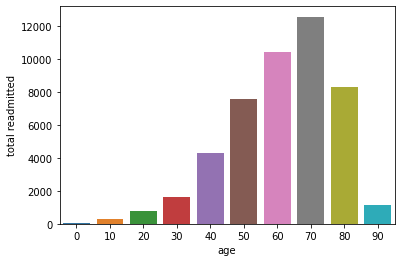

In [219]:
total_readmitted = rdf.groupby("age").agg(
    pl.col("is_readmitted").sum().alias("total readmitted")
)
total_readmitted.barplot(x="age", y="total readmitted")

In terms of the number of readmissions, we see a clear trend for readmission cases to increase with age, before dropping down in the 80-90 and 90-100 age groups. This may be due to increased mortality in these age ranges.

However, if we take a look at the mean number of cases per age group using `histplot`, we see that it follows the same trend, showing that this trend may not represent a higher risk of readmission for older patients, but rather a much increased number of diabetes patients in older age groups.

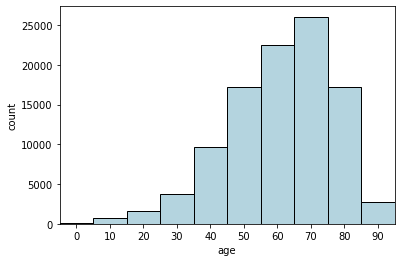

In [220]:
rdf.histplot(x="age")

If we zoom in on `short-term` and `long-term` readmittance individually and get the percentage of patients in these groups who are readmitted, rather than the count, we get a rather different picture.

To get these percentage values, we divide the total number of short-term or long-term values in the readmitted column by the total values in this column.

To get the total short-term or long-term values, we use the str.count_match function to fill the readmitted column with True (1) values where the contents of the cell are short-term or long-term respectively and False (0) for any other values. We can use the sum function to count up all of these True values.

To get the total values in the readmitted column, we select the column and use count() function.

We can then set the column name to whatever we like using the alias function.

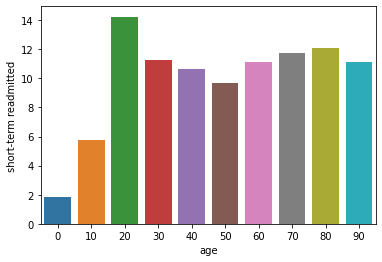

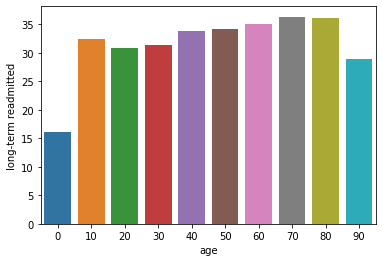

In [221]:
import matplotlib.pyplot as plt

short_term = rdf.groupby("age").agg(
    (
        pl.col("readmitted").str.count_match("short-term").sum()
        / pl.col("readmitted").count()
        * 100
    ).alias("short-term readmitted")
)
long_term = rdf.groupby("age").agg(
    (
        pl.col("readmitted").str.count_match("long-term").sum()
        / pl.col("readmitted").count()
        * 100
    ).alias("long-term readmitted")
)

short_term.barplot(x="age", y="short-term readmitted")
plt.show()
long_term.barplot(x="age", y="long-term readmitted")

We see a slight trend of increased long-term readmissions as age increases, but interestingly, a much higher risk of short-term readmission in 20-30 year olds. This could be explained by younger patients perhaps not having yet found the correct treatment or lifestyle to manage their diabetes.

Similarly, if we take a look at the average number of emergency visits in the past year for patients in each age category, the 20-30 group is the most at-risk.



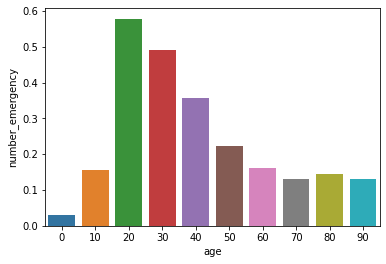

In [222]:
rdf.barplot(x="age", y="number_emergency")

These trends provide actionable insights, where advice or follow-ups with 20-30 year olds could be tailored based on their increased risk of short-term hospital readmission and emergency visits.

### A1C examinations as a factor in changes to medication and readmittance

Next, let's take a look at the impact of A1C levels being checked during the hospital admission on the likelihood of a patient's medication being changed. The higher the level of A1C, the greater the risk of developing diabetes complications is.

In [223]:
# group data by A1C result group
ret = rdf.groupby(pl.col("A1Cresult")).agg(
    [
        # get percentage of patients in each group who changed medication
        (pl.col("change").sum() / pl.col("change").count() * 100).alias("change"),
    ]
)

# display as a sorted list
ret.sort(pl.col("change"), reverse=True).collect().fetch()

A1Cresult,change
str,f64
"""very high""",65.067994
"""high""",50.738007
null,44.272954
"""normal""",44.226143


Perhaps as expected, those with a very high or high A1Cresult were more likely to have a medication change. Interestingly, those who do not have their A1C level examined are only as likely to change medication as those with normal A1C levels. This shows doctors are less likely to change medication unless they know that A1C levels are higher than expected via exams.

What we now want to know is whether this has an impact on the likelihood of patient readmission in the short and long term.

In [224]:
# percentages of those readmitted within a month of initial hospital visit by A1C result group
ret = rdf.groupby(pl.col("A1Cresult")).agg(
    [
        (
            pl.col("readmitted").str.count_match("short-term").sum()
            / pl.col("readmitted").count()
            * 100
        ).alias("short-term readmitted")
    ]
)
ret.sort(pl.col("short-term readmitted"), reverse=True).collect().fetch()

A1Cresult,short-term readmitted
str,f64
null,11.436393
"""high""",10.042172
"""very high""",9.907722
"""normal""",9.703288


In [225]:
# percentages of those readmitted in the long-term by A1C result group

ret = rdf.groupby(pl.col("A1Cresult")).agg(
    [
        (
            pl.col("readmitted").str.count_match("long-term").sum()
            / pl.col("readmitted").count()
            * 100
        ).alias("long-term readmitted")
    ]
)
ret.sort(pl.col("long-term readmitted"), reverse=True).collect().fetch()

A1Cresult,long-term readmitted
str,f64
"""very high""",35.271977
null,35.085608
"""high""",34.106484
"""normal""",31.996792


We see that patients who did not have their A1C level taken are the most likely to be readmitted in the short-term and almost as likely as their "very high" counterparts to be readmitted in the long-term. This suggests that taking patients' A1C levels can help encourage doctors to make changes in medication, which may be a factor in a reduction in hospital readmissions.

### Dosage increases and decreases as factors on overall readmission

We will now investigate the likelihood of increases or decreases of specific medications leading to short-term patient readmission.

Let's start by getting a list of the medications we want to look at. We will these lists down to drugs with more than 20 results to remove any medication with only a handful of results.

In [226]:
# list of all medications in study
all_meds = [
    "metformin",
    "repaglinide",
    "nateglinide",
    "chlorpropamide",
    "glimepiride",
    "acetohexamide",
    "glipizide",
    "glyburide",
    "tolbutamide",
    "pioglitazone",
    "rosiglitazone",
    "acarbose",
    "miglitol",
    "troglitazone",
    "tolazamide",
    "examide",
    "citoglipton",
    "insulin",
    "glyburide-metformin",
    "glipizide-metformin",
    "glimepiride-pioglitazone",
    "metformin-rosiglitazone",
    "metformin-pioglitazone",
]

# get the number of increased doses per medication and flip the output vertically
increased_meds = rdf.select(
    pl.col(x).str.count_match("Up").sum() for x in all_meds
).melt(variable_name="medication", value_name="count")

# remove any medications that don't have at least 100 rows of data and get this result as a Polars dataframe
increased_meds = increased_meds.filter(pl.col("count") > 20).collect().fetch()

# convert output to a list via Pandas API
increased_meds = increased_meds.to_pandas()["medication"].tolist()
increased_meds

['metformin',
 'repaglinide',
 'nateglinide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin']

We now do exactly the same for decreased medications.

In [227]:
# get the number of increased doses per medication and flip the output vertically
decreased_meds = rdf.select(
    pl.col(x).str.count_match("Down").sum() for x in all_meds
).melt(variable_name="medication", value_name="count")

# remove any medications that don't have at least 100 rows of data and get this result as a Polars dataframe
decreased_meds = decreased_meds.filter(pl.col("count") > 20).collect().fetch()

# convert output to a list via Pandas API
decreased_meds = decreased_meds.to_pandas()["medication"].tolist()
decreased_meds

['metformin',
 'repaglinide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin']

The next step is to loop over our list of `increased_meds` and get the percentage of patients who were readmitted to hospital within the following month after their dose of the drug was increased. We are able to use the `vstack` function to append each result for each drug into one table.

We then simply add a column with the list of medicines in the same order and sort the list from highest to lowest.

In [228]:
# create a null table value for later use
table = None

# iterate over medications list
for drugs in increased_meds:
    # filter data down to cases where dosage increased
    tmp = rdf.filter(pl.col(drugs) == "Up")
    # get a RemoteLazyFrame of percentages of patients where each drug is increased were readmitted to hospital during study
    percentages = tmp.select(
        [
            (
                pl.col("is_readmitted").sum() / pl.col("is_readmitted").count() * 100
            ).alias("overall readmitted %"),
        ]
    )
    # if first iteration, table and data_avilable are assigned percentages and row_count tables
    if table == None:
        table = percentages
    # else we use vstack to add new row of percentages
    else:
        table = table.vstack(percentages)

# convert table to Polars dataframe
table = table.collect().fetch()

# create and add new column with medication names
new_col = pl.Series("medication", increased_meds)
table = table.with_columns([new_col])
table.select(["medication", "overall readmitted %"]).sort(
    pl.col("overall readmitted %")
)

medication,overall readmitted %
str,f64
"""rosiglitazone""",39.88764
"""metformin""",40.76851
"""glimepiride""",42.507645
"""glyburide""",44.211823
"""nateglinide""",45.833333
"""repaglinide""",48.181818
"""glipizide""",50.0
"""insulin""",51.537646
"""pioglitazone""",51.709402


This gives us significiant results that merit further exploration with a difference of around 14% between the likelihood of an increased dose of our lowest and highest placed drugs on the list leading to readmission within the course of the study.

We can run the same query for a reduction in medication, again leading to significant results.

In [229]:
# create a null table value for later use
table = None

# iterate over medications list
for drugs in decreased_meds:
    # filter data down to cases where dosage increased
    tmp = rdf.filter(pl.col(drugs) == "Down")
    # get a RemoteLazyFrame of percentages of patients where each drug is increased were readmitted to hospital during study
    percentages = tmp.select(
        [
            (
                pl.col("is_readmitted").sum() / pl.col("is_readmitted").count() * 100
            ).alias("overall readmitted %"),
        ]
    )
    # if first iteration, table and data_avilable are assigned percentages and row_count tables
    if table == None:
        table = percentages
    # else we use vstack to add new row of percentages
    else:
        table = table.vstack(percentages)

table = table.collect().fetch()
new_col = pl.Series("medication", decreased_meds)
table = table.with_columns([new_col])
table.select(["medication", "overall readmitted %"]).sort(
    pl.col("overall readmitted %")
)

medication,overall readmitted %
str,f64
"""rosiglitazone""",31.034483
"""metformin""",45.043478
"""glimepiride""",47.938144
"""glyburide""",48.758865
"""repaglinide""",48.888889
"""insulin""",52.790964
"""glipizide""",52.857143
"""pioglitazone""",53.389831


We see that the first four drugs (rosiglitazone, metformin, glimepiride and glyburide) and last four drugs (repaglinide, insulin, glipizide and pioglitazone) in each list are the same, which could suggest that they are more effective overall treatments, regardless of whether they are increased or decreased. 

However, this could also be explained by these medications being prescribed for milder diabetes or these being the go-to drugs, aka. the bottom four drugs are only prescribed when patients are not responding well to medication. This would need to be considered by the client.

### Conclusions

This brings us to the end of our data exploration. We gained meaningful insights:

    - 20-30 year olds are the most at-risk age group of short-term hospital readmission and emergency visits.
    
    - The number of hospital admissions per age group increases with age.

    - Taking patients' A1C levels may encourage doctors to make changes in medication.
    
    - Not taking patients' A1C levels may increase the likelihood of hospital readmissions.

    - Regardless of dosage increases or decreases, the following medications appear most effective at reducing hospital readmissions: rosiglitazone, metformin, glimepiride and glyburide.

    - Regardless of dosage increases or decreases, the following medications appear less effective at reducing hospital readmissions: repaglinide, insulin, glipizide and pioglitazone.


This is a rich dataset with many avenues to explore, so feel free to continue exploring!

However in our case, that's all we've got time for! Let's close our connection and stop the server. 

(Leave this next block commented if you want to continue to run queries on the dataset instead!)


In [230]:
# connection.close()
# bastionlab_server.stop(srv)